<a href="https://colab.research.google.com/github/Ananyaa26/Image-Colorization-using-Deep-Learning/blob/main/DL_colorize_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras_preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os


In [ ]:
from keras.applications.vgg16 import VGG16
# load the model
vggmodel = VGG16()


In [ ]:
newmodel = Sequential()

In [ ]:
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
import glob
glob.glob("drive/My Drive/DL project/*.jpg")

[]

In [ ]:
path ="/content/drive/MyDrive/DL project/DL PROJECT/ColorfulOriginal"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255) # for relu activation function

train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None) #pretrained vgg accepts 224x224 sized images

Found 722 images belonging to 20 classes.


#Convert from RGB to Lab


In [ ]:

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])  #lightness channel
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)


(32, 224, 224, 1)
(32, 224, 224, 2)


#How does LAB looks like?

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


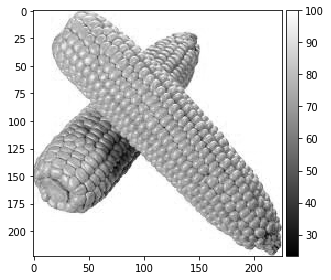

In [ ]:
from keras_preprocessing.image import load_img
from skimage.color import rgb2lab
from skimage.io import imshow

img=load_img('/content/drive/MyDrive/DL project/DL PROJECT/ColorfulOriginal/Corn/Corn5.jpg')
lab = rgb2lab(img)
L = lab[:,:,0]
A = lab[:,:,1]
B = lab[:,:,2]
imshow(L,cmap = 'gray')

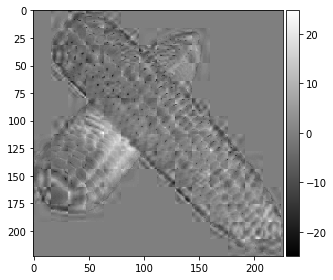

In [ ]:
imshow(A,cmap = 'gray')

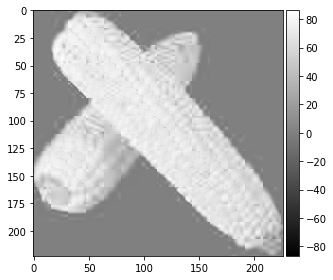

In [ ]:
imshow(B,cmap = 'gray')



#Convert the images to 3 channel to input it into VGG model




In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 1s 520ms/step
(32, 7, 7, 512)


#Sending VGG features to Dencoder

In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same')) #tan h activation function for negative values
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
history = model.fit(vggfeatures, Y, verbose=1, epochs=70, batch_size=128)

Epoch 1/70
1/1 [==============================] - 2s 2s/step - loss: 0.0146 - accuracy: 0.7137
Epoch 2/70
1/1 [==============================] - 1s 1s/step - loss: 0.0197 - accuracy: 0.7924
Epoch 3/70
1/1 [==============================] - 1s 1s/step - loss: 0.0153 - accuracy: 0.5999
Epoch 4/70
1/1 [==============================] - 1s 1s/step - loss: 0.0179 - accuracy: 0.5306
Epoch 5/70
1/1 [==============================] - 1s 1s/step - loss: 0.0151 - accuracy: 0.5705
Epoch 6/70
1/1 [==============================] - 1s 1s/step - loss: 0.0121 - accuracy: 0.6643
Epoch 7/70
1/1 [==============================] - 1s 1s/step - loss: 0.0108 - accuracy: 0.7440
Epoch 8/70
1/1 [==============================] - 1s 1s/step - loss: 0.0115 - accuracy: 0.7723
Epoch 9/70
1/1 [==============================] - 1s 1s/step - loss: 0.0119 - accuracy: 0.7561
Epoch 10/70
1/1 [==============================] - 1s 1s/step - loss: 0.0109 - accuracy: 0.7198
Epoch 11/70
1/1 [==============================] 

In [ ]:
model.save('colorize_autoencoder_VGG16.model')


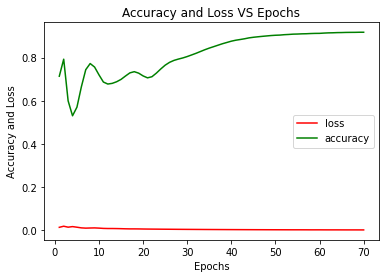

In [ ]:
import matplotlib.pyplot as plt
loss_model = history.history['loss']
acc_model = history.history['accuracy']
epochs = range(1,71)
plt.plot(epochs, loss_model, 'r', label='loss')
plt.plot(epochs, acc_model, 'g', label='accuracy')
plt.title('Accuracy and Loss VS Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Loss')
plt.legend()
plt.show()

In [ ]:
testpath = '/content/drive/MyDrive/DL project/DL PROJECT/testimages/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave('/content/drive/MyDrive/DL project/DL PROJECT/gray__vgg_result/result'+str(idx)+".jpg", lab2rgb(cur))

1/1 [==============================] - 0s 232ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 57ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1111 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 27 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 35 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 482 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 31 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 29ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 9 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 293 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


In [ ]:
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
!pip install image-similarity-measures
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, psnr

in_img1 = cv2.imread('/content/drive/MyDrive/DL project/DL PROJECT/ColorfulImages_of_testimages/Copy of carrot24.jpg') #y_true
in_img2 = cv2.imread('/content/drive/MyDrive/DL project/DL PROJECT/gray__vgg_result/result9.jpg') #y_pred

out_rmse = rmse(in_img1, in_img2)
out_psnr = psnr(in_img1, in_img2)

In [ ]:
out_rmse
#Root Mean Square Error (RMSE) measures the amount of change per pixel due to 
#the processing. RMSE values are non-negative and a value of 00 means the image or videos being compared are identical. 

0.007031158

In [ ]:
out_psnr

43.05946353605228

In [ ]:
import skimage.metrics
ssim = skimage.metrics.structural_similarity(in_img1, in_img2, multichannel=True)
ssim

0.8772185733317025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
